# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# Preprocessing 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import seaborn as sns
sns.set()

* Loading Data from sql database. Ignored neutral reviews that is score=3. And data is sorted according to time.

In [2]:
import sqlite3

conn = sqlite3.connect('Data/database.sqlite')

data = pd.read_sql_query("select * from Reviews where Score !=3 order by Time", conn)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
3,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
4,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


### Data Cleaning


* Same review from a user to a product in different time indicates duplicate data.
* Removed data that has same product ID, user id, score, text values.

In [3]:
# removing duplicates
data = data.drop_duplicates(subset={'ProductId', 'UserId', 'Score', 
                            'Text'}, keep='first')

### Data Segmentation

* First 25k positive and 25k negative data are considered from a data sorted by time.
* Then data is divided in 70-30 ratio for training and testing purposes.
* Combined positive and negative data for further analysis.

In [4]:
positiveData = {
    "Text": [],
    "Sentiment": [],
    "Time": []
}

negativeData = {
    "Text": [],
    "Sentiment": [],
    "Time": []    
}

n_posRneg = 25000
n_negative = 0
n_positive = 0

for row in data.itertuples():
    
    if row[7] < 3:
        if n_negative < n_posRneg:
            positiveData['Text'].append(row[10])
            positiveData['Sentiment'].append(-1)
            positiveData['Time'].append(row[8])
            n_negative += 1
    else:
        if n_positive < n_posRneg:
            negativeData['Text'].append(row[10])
            negativeData['Sentiment'].append(1)
            negativeData['Time'].append(row[8])
            n_positive += 1

positiveData = pd.DataFrame(positiveData).sort_values(['Time'], axis=0)
negativeData = pd.DataFrame(negativeData).sort_values(['Time'], axis=0)

In [5]:
te = int(2500 * 7)
positiveTrain = positiveData[0:te]
positiveTest = positiveData[te:25000]
negativeTrain = negativeData[0:te]
negativeTest = negativeData[te:25000]

In [6]:
trainData = pd.concat([positiveTrain, negativeTrain], axis=0)
trainData = trainData.sort_values(['Time'], axis=0)
X_train = trainData['Text']
Y_train = trainData['Sentiment']

testData = pd.concat([positiveTest, negativeTest], axis=0)
testData = testData.sort_values(['Time'], axis=0)
X_test = testData['Text']
Y_test = testData['Sentiment']

### Data Cleaning

* Removed html tags, punctuations from each sentence.
* Each word is lowercased and removed stop words(a, an, the....).

In [8]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

snow = SnowballStemmer('english')
pre_processedTrain = []

i = 0
N = 35000
for sentence in X_train:    
    sentence = str(sentence)
    sentence = sentence.lower()
    clnr = re.compile('<.*?>') # for cleaning html tags
    sentence = re.sub(clnr, ' ', sentence)
    sentence = re.sub(r'[?|!|\'|"|#]', r'', sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]', r' ', sentence) 
    
    words = [snow.stem(word) for word in sentence.split() \
             if word not in stopwords.words('english')]
    final_sentence = ''
    for word in words:
        final_sentence = final_sentence + word + ' '
    pre_processedTrain.append(final_sentence)
    print("{0:.2f} %".format(i/N*100), end='\r')
    i += 1

In [9]:
pre_processedTest = []

i = 0
N = 15000
for sentence in X_test:    
    sentence = str(sentence)
    sentence = sentence.lower()
    clnr = re.compile('<.*?>') # for cleaning html tags
    sentence = re.sub(clnr, ' ', sentence)
    sentence = re.sub(r'[?|!|\'|"|#]', r'', sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]', r' ', sentence) 
    
    words = [snow.stem(word) for word in sentence.split() \
             if word not in stopwords.words('english')]
    final_sentence = ''
    for word in words:
        final_sentence = final_sentence + word + ' '
    pre_processedTest.append(final_sentence)
    print("{0:.2f} %".format(i/N*100), end='\r')
    i += 1

# Bag of Words

* Trained bag of words by using training data. Transformed training and testing data to numerical vectors.
* Considered only top most 1500 important words.
* Each sentence is converted into a vector of size 1500.

In [18]:
# Training Bag of words
from sklearn.feature_extraction.text import CountVectorizer

bow_model = CountVectorizer(max_features=1500)
bow_train = bow_model.fit_transform(pre_processedTrain)
bow_test = bow_model.transform(pre_processedTest)

## GBDT

* Training GBDT using XGBClassifier from xgboost module.
* Grid search is used for searching best maximum depth and number of best estimators.
* Trained on bag of words data.

In [55]:
# searching for best hyperparameter
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[i for i in range(1, 122, 40)],
                 'n_estimators':[i for i in range(50, 201, 50)]}
classifier_ = XGBClassifier(booster='gbtree')

search_hyp = GridSearchCV(classifier_, parameters, cv=5, n_jobs=3)

In [56]:
import warnings
warnings.filterwarnings("ignore")

search_hyp.fit(bow_train, Y_train)
search_hyp.best_params_

{'max_depth': 81, 'n_estimators': 200}

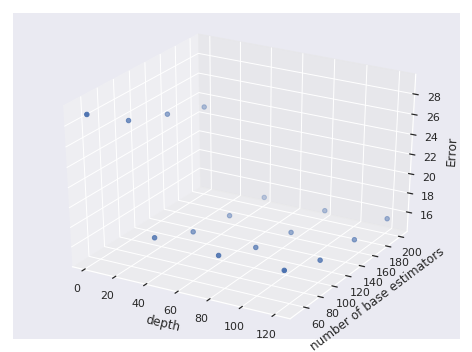

In [72]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

te1 = []
te2 = []
for i in range(len(parameters['max_depth'])):
    for k in range(len(parameters['max_depth'])):
        te1.append(parameters['max_depth'][i])
    for k in range(len(parameters['n_estimators'])):
        te2.append(parameters['n_estimators'][k])

test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(te1, te2, test_errors)

ax.set_xlabel('depth')
ax.set_ylabel('number of base estimators')
ax.set_zlabel('Error')
plt.show()

Optimal depth is 41 and optimal number of base learners is 175

In [68]:
# training final model
classifier = XGBClassifier(booster='gbtree',
                            n_estimators=search_hyp.best_params_['n_estimators'],
                            max_depth=search_hyp.best_params_['max_depth'])
classifier.fit(bow_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=81, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [69]:
# performence metrics

from sklearn import metrics
pred = classifier.predict(bow_test)

tr_score = classifier.score(bow_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

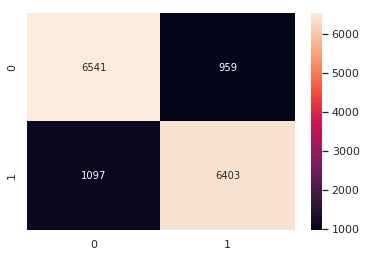

In [71]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')

## Random Forest

* Training Random Forest using RandomForestClassifier from sklearn.ensemble .
* Grid search is used for searching best maximum depth and number of best estimators.
* Trained on bag of words data.

In [73]:
from sklearn.ensemble import RandomForestClassifier
parameters = {'max_depth':[i for i in range(1, 122, 40)],
                 'n_estimators':[i for i in range(50, 201, 50)]}
classifier_ = RandomForestClassifier()

search_hyp = GridSearchCV(classifier_, parameters, cv=5, n_jobs=3)

In [74]:
search_hyp.fit(bow_train, Y_train)
search_hyp.best_params_

{'max_depth': 81, 'n_estimators': 200}

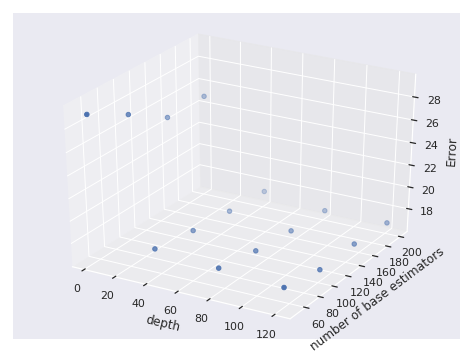

In [75]:
te1 = []
te2 = []
for i in range(len(parameters['max_depth'])):
    for k in range(len(parameters['max_depth'])):
        te1.append(parameters['max_depth'][i])
    for k in range(len(parameters['n_estimators'])):
        te2.append(parameters['n_estimators'][k])

test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(te1, te2, test_errors)

ax.set_xlabel('depth')
ax.set_ylabel('number of base estimators')
ax.set_zlabel('Error')
plt.show()

* Optimal depth is 81 and optimal number of base learners is 200

In [76]:
classifier = RandomForestClassifier(n_estimators=search_hyp.best_params_['n_estimators'],
                            max_depth=search_hyp.best_params_['max_depth'])
classifier.fit(bow_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=81, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [77]:
# performence measures
pred = classifier.predict(bow_test)

tr_score = classifier.score(bow_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

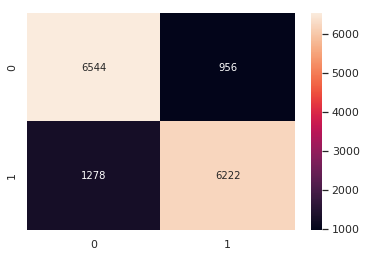

In [79]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')

# Tf-Idf

* Trained tf-idf by using training data. Transformed training and testing data to numerical vectors.
* TfidfVectorizer from sklearn is used.
* Considered only top most 1500 important words.
* Each sentence is converted into a vector of size 1500.


In [37]:
# Training tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer(max_features=1500)
tfidf_train = tfidf_model.fit_transform(pre_processedTrain)
tfidf_test = tfidf_model.transform(pre_processedTest)

## GBDT

* Training GBDT using XGBClassifier from xgboost module.
* Grid search is used for searching best maximum depth and number of best estimators.
* Trained on tf - idf data.

In [87]:
parameters = {'max_depth':[i for i in range(1, 122, 40)],
                 'n_estimators':[i for i in range(50, 201, 50)]}
classifier_ = XGBClassifier(booster='gbtree')

search_hyp = GridSearchCV(classifier_, parameters, cv=5, n_jobs=3)

In [88]:
search_hyp.fit(tfidf_train, Y_train)
search_hyp.best_params_

{'max_depth': 41, 'n_estimators': 200}

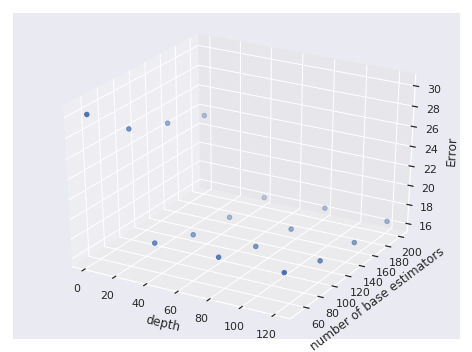

In [89]:
te1 = []
te2 = []
for i in range(len(parameters['max_depth'])):
    for k in range(len(parameters['max_depth'])):
        te1.append(parameters['max_depth'][i])
    for k in range(len(parameters['n_estimators'])):
        te2.append(parameters['n_estimators'][k])

test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(te1, te2, test_errors)

ax.set_xlabel('depth')
ax.set_ylabel('number of base estimators')
ax.set_zlabel('Error')
plt.show()

optimal depth is 41 and optimal number of base estimators is 200

In [90]:
classifier = XGBClassifier(booster='gbtree',
                            n_estimators=search_hyp.best_params_['n_estimators'],
                            max_depth=search_hyp.best_params_['max_depth'])
classifier.fit(tfidf_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=41, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [91]:
from sklearn import metrics
pred = classifier.predict(tfidf_test)

tr_score = classifier.score(bow_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

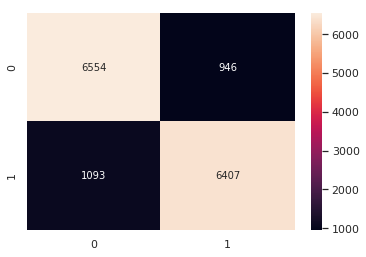

In [93]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')

## Random Forest

* Training Random Forest using RandomForestClassifier from sklearn.ensemble .
* Grid search is used for searching best maximum depth and number of best estimators.
* Trained on tf-idf data.

In [94]:
parameters = {'max_depth':[i for i in range(1, 122, 40)],
                 'n_estimators':[i for i in range(50, 201, 50)]}
classifier_ = RandomForestClassifier()

search_hyp = GridSearchCV(classifier_, parameters, cv=5, n_jobs=-1)

In [96]:
search_hyp.fit(tfidf_train, Y_train)
search_hyp.best_params_

{'max_depth': 121, 'n_estimators': 200}

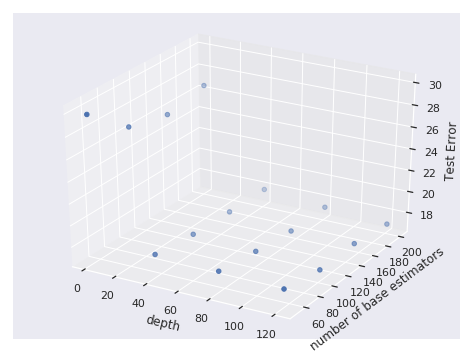

In [97]:
te1 = []
te2 = []
for i in range(len(parameters['max_depth'])):
    for k in range(len(parameters['max_depth'])):
        te1.append(parameters['max_depth'][i])
    for k in range(len(parameters['n_estimators'])):
        te2.append(parameters['n_estimators'][k])

test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(te1, te2, test_errors)

ax.set_xlabel('depth')
ax.set_ylabel('number of base estimators')
ax.set_zlabel('Test Error')
plt.show()

Optimal depth is 121 and optimal number of base learners is 200.

In [98]:
classifier = RandomForestClassifier(n_estimators=search_hyp.best_params_['n_estimators'],
                            max_depth=search_hyp.best_params_['max_depth'])
classifier.fit(tfidf_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=121, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [99]:
pred = classifier.predict(tfidf_test)

tr_score = classifier.score(bow_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

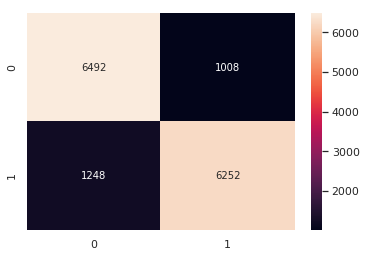

In [101]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')

# Word2vec

* Trained own word2vec using gensim module. Considered words which has frequency more than 5 in whole data.
* Trained word2vec using Word2vec function from gensim.models.
* Trained for vector of size 150. And converted each word into a vector of size 150.
* Added all vectors of a sentence and divided with total number of vectors in sentence. So that we can get average word2vec value for each sentence.

In [10]:
import warnings
warnings.filterwarnings("ignore")

# training word2vec on training data
from gensim.models import Word2Vec
sentences = []
for row in X_train:
    sentences.append([word for word in row.split()])

w2v = Word2Vec(sentences, min_count=5, size=150, workers=3)
avgw2v_dataTrain = []
for row in sentences:
    te = [0 for i in range(150)]
    num = 0
    for word in row:
        try:
            te += w2v[word]
            num += 1
        except:
            pass
    avgw2v_dataTrain.append(te/num)

In [19]:
# converting test data

sentences = []
for row in X_test:
    sentences.append([word for word in row.split()])

avgw2v_dataTest = []
for row in sentences:
    te = [0 for i in range(150)]
    num = 0
    for word in row:
        try:
            te += w2v[word]
            num += 1
        except:
            pass
    avgw2v_dataTest.append(te/num)

## GBDT

* Training GBDT using XGBClassifier from xgboost module.
* Grid search is used for searching best maximum depth and number of best estimators.
* Trained on average word2vec data.

In [11]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

parameters = {'max_depth':[i for i in range(1, 122, 40)],
                 'n_estimators':[i for i in range(50, 101, 25)]}
classifier_ = XGBClassifier(booster='gbtree')

search_hyp = GridSearchCV(classifier_, parameters, cv=5, n_jobs=-1)

In [12]:
search_hyp.fit(np.array(avgw2v_dataTrain), Y_train)
search_hyp.best_params_

{'max_depth': 41, 'n_estimators': 100}

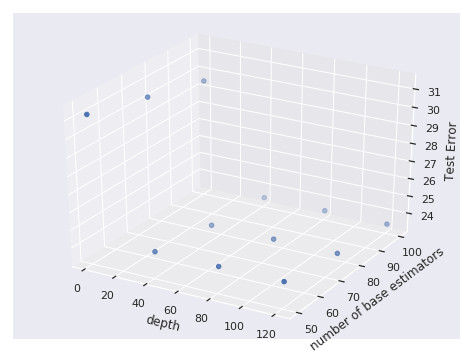

In [17]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

te1 = []
te2 = []
for i in range(len(parameters['max_depth'])):
    for k in range(len(parameters['n_estimators'])):
        te1.append(parameters['max_depth'][i])
    for k in range(len(parameters['n_estimators'])):
        te2.append(parameters['n_estimators'][k])

test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(te1, te2, test_errors)

ax.set_xlabel('depth')
ax.set_ylabel('number of base estimators')
ax.set_zlabel('Test Error')
plt.show()

* Optimal depth 41 is and optimal number of base estimators is 100.

In [18]:
classifier = XGBClassifier(booster='gbtree',
                            n_estimators=search_hyp.best_params_['n_estimators'],
                            max_depth=search_hyp.best_params_['max_depth'])
classifier.fit(np.array(avgw2v_dataTrain), Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=41, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [20]:
from sklearn import metrics
pred = classifier.predict(np.array(avgw2v_dataTest))

tr_score = classifier.score(np.array(avgw2v_dataTrain), Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

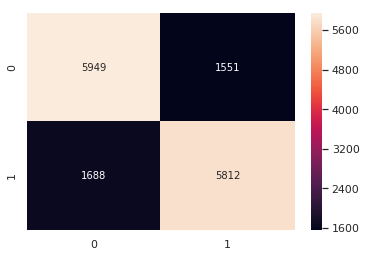

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')

## Random Forest

* Training Random Forest using RandomForestClassifier from sklearn.ensemble .
* Grid search is used for searching best maximum depth and number of best estimators.
* Trained on average word2vec data.

In [30]:
from sklearn.ensemble import RandomForestClassifier

parameters = {'max_depth':[i for i in range(1, 122, 40)],
                 'n_estimators':[i for i in range(50, 101, 25)]}
classifier_ = RandomForestClassifier()

search_hyp = GridSearchCV(classifier_, parameters, cv=5, n_jobs=-1)

In [31]:
search_hyp.fit(np.array(avgw2v_dataTrain), Y_train)
search_hyp.best_params_

{'max_depth': 81, 'n_estimators': 100}

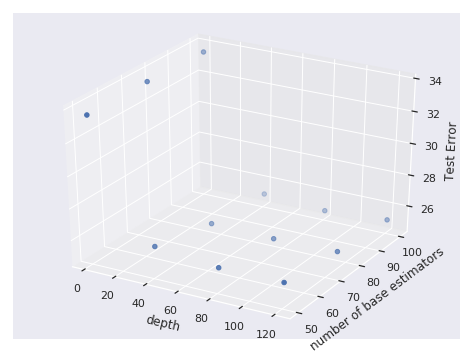

In [32]:
te1 = []
te2 = []
for i in range(len(parameters['max_depth'])):
    for k in range(len(parameters['n_estimators'])):
        te1.append(parameters['max_depth'][i])
    for k in range(len(parameters['n_estimators'])):
        te2.append(parameters['n_estimators'][k])

test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(te1, te2, test_errors)

ax.set_xlabel('depth')
ax.set_ylabel('number of base estimators')
ax.set_zlabel('Test Error')
plt.show()

* optimal depth is 81 and optimal number of base estimators is 100.

In [33]:
classifier = RandomForestClassifier(n_estimators=search_hyp.best_params_['n_estimators'],
                            max_depth=search_hyp.best_params_['max_depth'])
classifier.fit(np.array(avgw2v_dataTrain), Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=81, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [34]:
# metrics
pred = classifier.predict(np.array(avgw2v_dataTest))

tr_score = classifier.score(np.array(avgw2v_dataTrain), Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

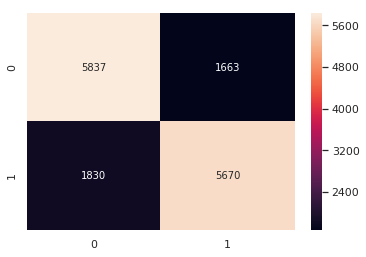

In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')

# Tf-IDF word2vec

* Using pre-trained tf-idf vectors and word2vec of size 150.
* Multiplying each word's word2vec vector and tf-idf value of that word in respected sentence.
* Executing above step for each word in a sentence and took sum of values of all words in a sentence.
* And this sum is divided by sum of tf-idf values of all words in sentences. Finally gives tf-idf word2vec values of size 150 for each sentence.

In [40]:
tfidf_train = tfidf_train.toarray()
tfidf_test = tfidf_test.toarray()

In [41]:
sentences = []
for row in pre_processedTrain:
    sentences.append([word for word in row.split()])

tfidfw2v_train = []
i = 0
for row in sentences:
    te = [0 for i in range(150)]
    
    temp_tfidf = []
    for val in tfidf_train[i]:
        if val != 0:
            temp_tfidf.append(val)
    
    num = 0
    tf_idf_sum = 0
    for word in row:
        try:
            num += 1
            tf_idf_sum = tf_idf_sum + temp_tfidf[num-1]
            te += (temp_tfidf[num-1] * w2v[word])
        except:
            pass
    try: # avoiding divide by zero
        te = (float)(1/tf_idf_sum) * te
    except:
        pass
    tfidfw2v_train.append(te)
    i = i + 1

In [43]:
sentences = []
for row in pre_processedTest:
    sentences.append([word for word in row.split()])

tfidfw2v_test = []
i = 0
for row in sentences:
    te = [0 for i in range(150)]
    
    temp_tfidf = []
    for val in tfidf_test[i]:
        if val != 0:
            temp_tfidf.append(val)
    
    num = 0
    tf_idf_sum = 0
    for word in row:
        try:
            num += 1
            tf_idf_sum = tf_idf_sum + temp_tfidf[num-1]
            te += (temp_tfidf[num-1] * w2v[word])
        except:
            pass
    try: # avoiding divide by zero
        te = (float)(1/tf_idf_sum) * te
    except:
        pass
    tfidfw2v_test.append(te)
    i = i + 1

## GBDT

* Training GBDT using XGBClassifier from xgboost module.
* Grid search is used for searching best maximum depth and number of best estimators.
* Trained on tf-idf word2vec data.

In [44]:
parameters = {'max_depth':[i for i in range(1, 122, 40)],
                 'n_estimators':[i for i in range(50, 101, 25)]}
classifier_ = XGBClassifier()

search_hyp = GridSearchCV(classifier_, parameters, cv=5, n_jobs=-1)

In [45]:
search_hyp.fit(np.array(tfidfw2v_train), Y_train)
search_hyp.best_params_

{'max_depth': 41, 'n_estimators': 100}

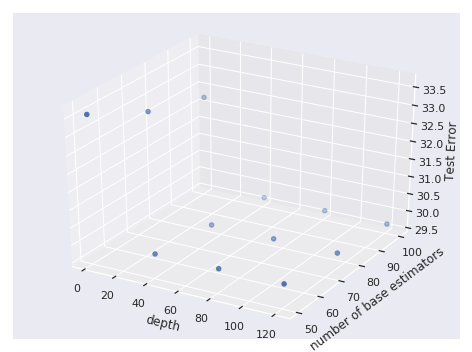

In [46]:
te1 = []
te2 = []
for i in range(len(parameters['max_depth'])):
    for k in range(len(parameters['n_estimators'])):
        te1.append(parameters['max_depth'][i])
    for k in range(len(parameters['n_estimators'])):
        te2.append(parameters['n_estimators'][k])

test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(te1, te2, test_errors)

ax.set_xlabel('depth')
ax.set_ylabel('number of base estimators')
ax.set_zlabel('Test Error')
plt.show()

* Optimal depth is 41 and optimal number of base learners is 100

In [47]:
classifier = XGBClassifier(n_estimators=search_hyp.best_params_['n_estimators'],
                            max_depth=search_hyp.best_params_['max_depth'])
classifier.fit(np.array(tfidfw2v_train), Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=41, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [48]:
from sklearn import metrics
pred = classifier.predict(np.array(tfidfw2v_test))

tr_score = classifier.score(np.array(tfidfw2v_train), Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

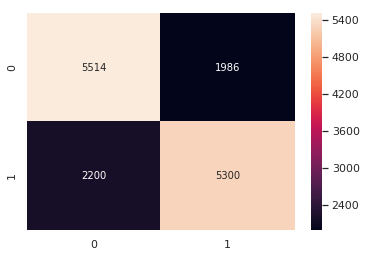

In [50]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')

## Random Forest

* Training Random Forest using RandomForestClassifier from sklearn.ensemble .
* Grid search is used for searching best maximum depth and number of best estimators.
* Trained on tf-idf word2vec data.

In [51]:
parameters = {'max_depth':[i for i in range(1, 122, 40)],
                 'n_estimators':[i for i in range(50, 101, 25)]}
classifier_ = RandomForestClassifier()

search_hyp = GridSearchCV(classifier_, parameters, cv=5, n_jobs=-1)

In [52]:
search_hyp.fit(np.array(tfidfw2v_train), Y_train)
search_hyp.best_params_

{'max_depth': 81, 'n_estimators': 100}

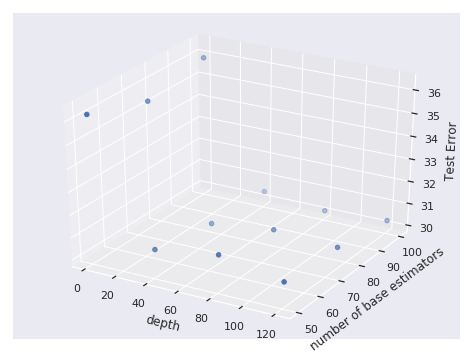

In [53]:
te1 = []
te2 = []
for i in range(len(parameters['max_depth'])):
    for k in range(len(parameters['n_estimators'])):
        te1.append(parameters['max_depth'][i])
    for k in range(len(parameters['n_estimators'])):
        te2.append(parameters['n_estimators'][k])

test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(te1, te2, test_errors)

ax.set_xlabel('depth')
ax.set_ylabel('number of base estimators')
ax.set_zlabel('Test Error')
plt.show()

* optimal depth is 81 and optimal number of base learners is 100.

In [54]:
classifier = RandomForestClassifier(n_estimators=search_hyp.best_params_['n_estimators'],
                            max_depth=search_hyp.best_params_['max_depth'])
classifier.fit(np.array(tfidfw2v_train), Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=81, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [55]:
# metrics
pred = classifier.predict(np.array(tfidfw2v_test))

tr_score = classifier.score(np.array(tfidfw2v_train), Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

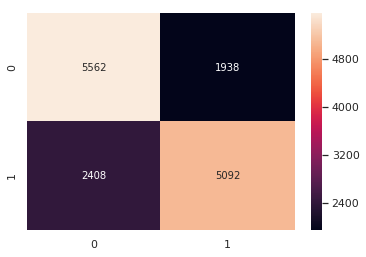

In [57]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')

# Conclusion

In [64]:
pd.DataFrame(performence, columns=header)

,Algorithm,Vectorizer,Depth,Number of estimators,Training score,test accuracy,Precision,Recall,f1-score
0,GBDT,Bag of Words,41,200,99.96,86.29,86.97,85.37,86.17
1,Random Forest,Bag of Words,81,200,99.41,85.11,86.68,82.96,84.78
2,GBDT,tf-idf,41,200,85.76,86.41,87.13,85.43,86.27
3,Random Forest,tf-idf,121,200,95.37,84.96,86.12,83.36,84.72
4,GBDT,Avg word2vec,41,100,100.00,78.41,78.94,77.49,78.21
5,Random Forest,Avg word2vec,81,100,100.00,76.71,77.32,75.60,76.45
6,GBDT,tf-idf word2vec,41,100,99.98,72.09,72.74,70.67,71.69
7,Random Forest,tf-idf word2vec,81,100,99.98,71.03,72.43,67.89,70.09


* Got better test accuracy for GBDT with Bag of words and tf-idf. 
* But GBDT took more execution time when compared with Random Forest.
* If accuracy matters -> GBDT with bag of words or tf-idf is best model.
* If time matters -> Random Forest with Average word2vec is best model.